In [48]:
!pip uninstall -y survivalist

Found existing installation: survivalist 0.1.1
Uninstalling survivalist-0.1.1:
  Successfully uninstalled survivalist-0.1.1


In [49]:
#!pip install git+https://github.com/thierrymoudiki/survivalist --upgrade --no-cache-dir
!pip install ../ --upgrade --no-cache-dir

Processing /workspaces/survivalist
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for survivalist: filename=survivalist-0.1.1-cp312-cp312-linux_x86_64.whl size=793911 sha256=57fc1bdfedd98213c28917d735c1e96ffd2cfaa6cfc0289d19ed7ee9e8918d87
  Stored in directory: /tmp/pip-ephem-wheel-cache-79ueb7hw/wheels/86/4a/06/a688008216a1c19b53b6af93534dead9ca55c8a539e4d4fe78
Successfully built survivalist


In [50]:
import numpy as np

In [51]:
import pandas as pd

def _encode_categorical_columns(df, categorical_columns=None):
    """
    Automatically identifies categorical columns and applies one-hot encoding.

    Parameters:
    - df (pd.DataFrame): The input DataFrame with mixed continuous and categorical variables.
    - categorical_columns (list): Optional list of column names to treat as categorical.

    Returns:
    - pd.DataFrame: A new DataFrame with one-hot encoded categorical columns.
    """
    # Automatically identify categorical columns if not provided
    if categorical_columns is None:
        categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()

    # Apply one-hot encoding to the identified categorical columns
    df_encoded = pd.get_dummies(df, columns=categorical_columns)

    # Convert boolean columns to integer (0 and 1)
    bool_columns = df_encoded.select_dtypes(include=['bool']).columns.tolist()
    df_encoded[bool_columns] = df_encoded[bool_columns].astype(int)

    return df_encoded


In [52]:
import matplotlib.pyplot as plt
from survivalist.datasets import load_whas500, load_gbsg2, load_veterans_lung_cancer
from survivalist.ensemble import ComponentwiseGenGradientBoostingSurvivalAnalysis
from survivalist.custom import SurvivalCustom
from survivalist.ensemble import GradientBoostingSurvivalAnalysis
from sklearn.linear_model import RidgeCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import ExtraTreeRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X, y = load_veterans_lung_cancer()#load_whas500() #load_gbsg2() #load_veterans_lung_cancer()
X = _encode_categorical_columns(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [53]:
estimator = ComponentwiseGenGradientBoostingSurvivalAnalysis(regr = RidgeCV(), loss="coxph")
estimator2 = ComponentwiseGenGradientBoostingSurvivalAnalysis(regr = ExtraTreeRegressor(), loss="coxph")
estimator3 = ComponentwiseGenGradientBoostingSurvivalAnalysis(regr = KernelRidge(), loss="coxph")
estimator4 = ComponentwiseGenGradientBoostingSurvivalAnalysis(regr = ElasticNetCV(), loss="coxph")
estimator5 = SurvivalCustom(regr = RidgeCV())
estimator6 = SurvivalCustom(regr = RandomForestRegressor())
estimator7 = GradientBoostingSurvivalAnalysis()

estimator.fit(X_train, y_train)
estimator2.fit(X_train, y_train)
estimator3.fit(X_train, y_train)
estimator4.fit(X_train, y_train) # [00:02<00:00, 38.25it/s]
estimator5.fit(X_train, y_train) # [00:02<00:00, 34.41it/s]
estimator6.fit(X_train, y_train) # [00:09<00:00, 10.15it/s]
estimator7.fit(X_train, y_train) # [01:58<00:00,  1.19s/it]

100%|██████████| 100/100 [00:52<00:00,  1.92it/s]


GradientBoostingSurvivalAnalysis()

In [54]:
surv_funcs = estimator.predict_survival_function(X_test.iloc[:1])
surv_funcs2 = estimator2.predict_survival_function(X_test.iloc[:1])
surv_funcs3 = estimator3.predict_survival_function(X_test.iloc[:1])
surv_funcs4 = estimator4.predict_survival_function(X_test.iloc[:1])
surv_funcs5 = estimator5.predict_survival_function(X_test.iloc[:1])
surv_funcs6 = estimator6.predict_survival_function(X_test.iloc[:1])
surv_funcs7 = estimator7.predict_survival_function(X_test.iloc[:1])

In [55]:
event_time = [y[1] for y in y_test]
event_status = [y[0] for y in y_test]

In [56]:
from survivalist.nonparametric import kaplan_meier_estimator

km = kaplan_meier_estimator(event_status, event_time,
                            conf_type="log-log")

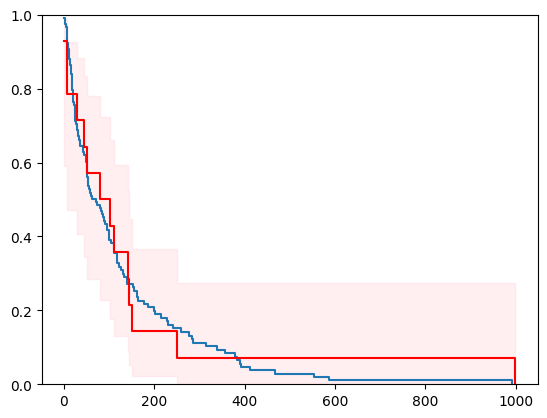

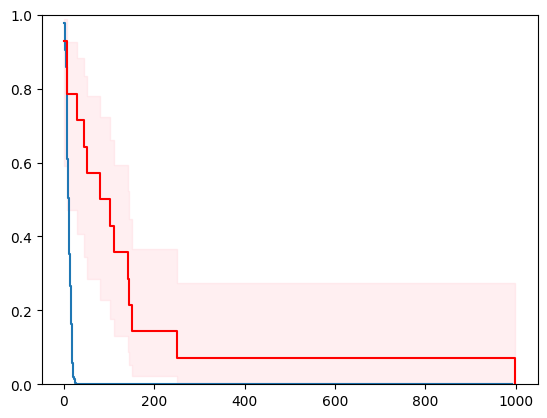

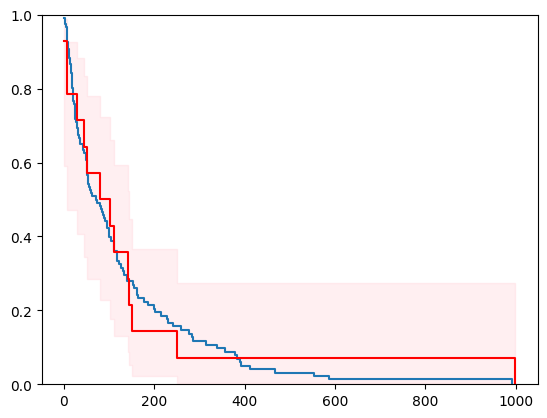

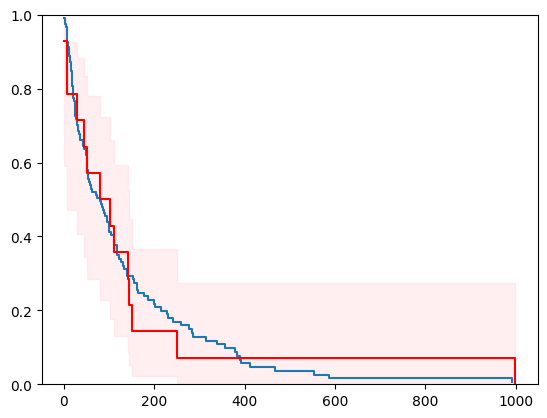

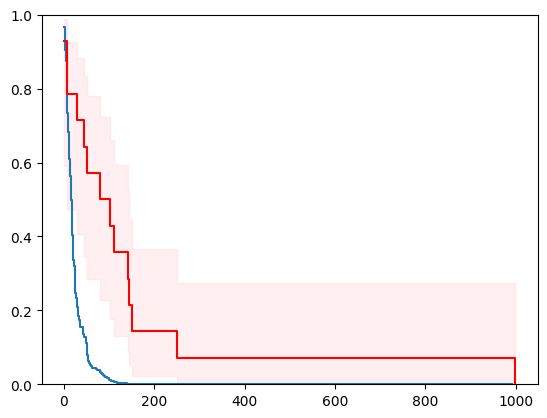

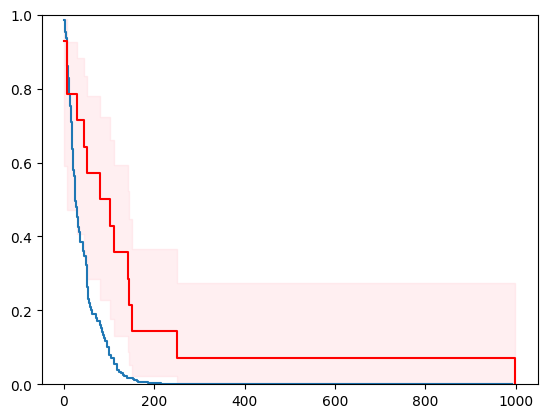

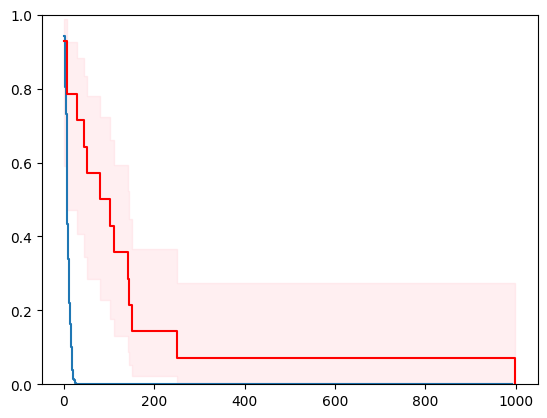

In [57]:
for fn in surv_funcs:
    plt.step(fn.x, fn(fn.x), where="post")
    #plt.title(f"RidgeCV vs Kaplan_Meier ({np.round(score_ridgecv, 2)})")
    plt.step(km[0], km[1], where="post", color="red", label="Kaplan-Meier")
    plt.fill_between(km[0], km[2][0], km[2][1], alpha=0.25, color="pink", step="post")
    plt.ylim(0, 1)
    plt.show()


for fn in surv_funcs2:
    plt.step(fn.x, fn(fn.x), where="post")
    #plt.title(f"ExtraTreeRegressor vs Kaplan_Meier ({np.round(score_extra, 2)})")
    plt.step(km[0], km[1], where="post", color="red", label="Kaplan-Meier")
    plt.fill_between(km[0], km[2][0], km[2][1], alpha=0.25, color="pink", step="post")
    plt.ylim(0, 1)
    plt.show()

for fn in surv_funcs3:
    plt.step(fn.x, fn(fn.x), where="post")
    #plt.title(f"KernelRidge vs Kaplan_Meier ({np.round(score_kernel, 2)})")
    plt.step(km[0], km[1], where="post", color="red", label="Kaplan-Meier")
    plt.fill_between(km[0], km[2][0], km[2][1], alpha=0.25, color="pink", step="post")
    plt.ylim(0, 1)
    plt.show()

for fn in surv_funcs4:
    plt.step(fn.x, fn(fn.x), where="post")
    #plt.title(f"ElasticNetCV vs Kaplan_Meier ({np.round(score_elastic, 2)})")
    plt.step(km[0], km[1], where="post", color="red", label="Kaplan-Meier")
    plt.fill_between(km[0], km[2][0], km[2][1], alpha=0.25, color="pink", step="post")
    plt.ylim(0, 1)
    plt.show()

for fn in surv_funcs5:
    plt.step(fn.x, fn(fn.x), where="post")
    #plt.title(f"SurvivalCustom(RidgeCV) ({np.round(score_custom, 2)})")
    plt.step(km[0], km[1], where="post", color="red", label="Kaplan-Meier")
    plt.fill_between(km[0], km[2][0], km[2][1], alpha=0.25, color="pink", step="post")
    plt.ylim(0, 1)
    plt.show()

for fn in surv_funcs6:
    plt.step(fn.x, fn(fn.x), where="post")
    #plt.title(f"SurvivalCustom(RandomForestRegressor) ({np.round(score_random, 2)})")
    plt.step(km[0], km[1], where="post", color="red", label="Kaplan-Meier")
    plt.fill_between(km[0], km[2][0], km[2][1], alpha=0.25, color="pink", step="post")
    plt.ylim(0, 1)
    plt.show()

for fn in surv_funcs7:
    plt.step(fn.x, fn(fn.x), where="post")
    #plt.title(f"GradientBoostingSurvivalAnalysis ({np.round(score_gradient, 2)})")
    plt.step(km[0], km[1], where="post", color="red", label="Kaplan-Meier")
    plt.fill_between(km[0], km[2][0], km[2][1], alpha=0.25, color="pink", step="post")
    plt.ylim(0, 1)
    plt.show()

In [58]:
estimator = ComponentwiseGenGradientBoostingSurvivalAnalysis(regr = RidgeCV(), loss="ipcwls")
estimator2 = ComponentwiseGenGradientBoostingSurvivalAnalysis(regr = ExtraTreeRegressor(), loss="ipcwls")
estimator3 = ComponentwiseGenGradientBoostingSurvivalAnalysis(regr = KernelRidge(), loss="ipcwls")

estimator.fit(X_train, y_train)
estimator2.fit(X_train, y_train)
estimator3.fit(X_train, y_train)

100%|██████████| 100/100 [00:01<00:00, 82.83it/s]


ComponentwiseGenGradientBoostingSurvivalAnalysis(loss='ipcwls',
                                                 regr=KernelRidge())

## Conformal prediction

In [59]:
from sklearn.model_selection import train_test_split


X_train_train, X_train_cal, y_train_train, y_train_cal = train_test_split(X_train, y_train, test_size=0.5)

In [60]:
display(X_train_train.shape)
display(X_train_cal.shape)

(61, 11)

(62, 11)

  4%|▍         | 4/100 [00:00<00:02, 32.19it/s]

100%|██████████| 100/100 [00:02<00:00, 34.34it/s]


Time to fit PIRandomForestRegressor:  5.976923942565918


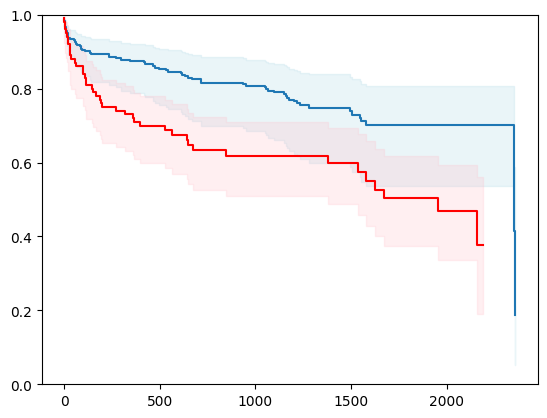

In [61]:
from survivalist.ensemble import PIComponentwiseGenGradientBoostingSurvivalAnalysis
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from time import time

X, y = load_whas500()
X = _encode_categorical_columns(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

event_time = [y[1] for y in y_test]
event_status = [y[0] for y in y_test]
km = kaplan_meier_estimator(event_status, event_time,
                            conf_type="log-log")
estimator = PIComponentwiseGenGradientBoostingSurvivalAnalysis(regr=RidgeCV(), type_pi="bootstrap")
estimator2 = GradientBoostingSurvivalAnalysis()

start = time()
estimator.fit(X_train, y_train)
print("Time to fit PIRandomForestRegressor: ", time() - start)

surv_funcs = estimator.predict_survival_function(X_test.iloc[:1])

for fn in surv_funcs.mean:
    plt.step(fn.x, fn(fn.x), where="post")
    plt.fill_between(fn.x, surv_funcs.lower[0].y, surv_funcs.upper[0].y, alpha=0.25, color="lightblue", step="post")
    plt.step(km[0], km[1], where="post", color="red", label="Kaplan-Meier")
    plt.fill_between(km[0], km[2][0], km[2][1], alpha=0.25, color="pink", step="post")
    plt.ylim(0, 1)
    plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:01<00:00, 65.45it/s]


Time to fit PIRandomForestRegressor:  3.0883469581604004


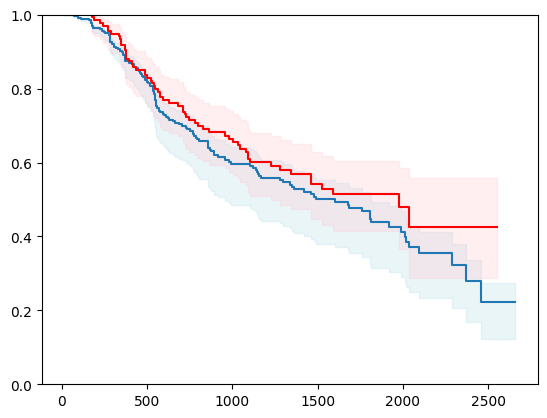

In [62]:
X, y = load_gbsg2()
X = _encode_categorical_columns(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

event_time = [y[1] for y in y_test]
event_status = [y[0] for y in y_test]
km = kaplan_meier_estimator(event_status, event_time,
                            conf_type="log-log")
estimator = PIComponentwiseGenGradientBoostingSurvivalAnalysis(regr=RidgeCV(), type_pi="kde")

start = time()
estimator.fit(X_train, y_train)
print("Time to fit PIRandomForestRegressor: ", time() - start)

surv_funcs = estimator.predict_survival_function(X_test.iloc[:1])


for fn in surv_funcs.mean:
    plt.step(fn.x, fn(fn.x), where="post")
    plt.fill_between(fn.x, surv_funcs.lower[0].y, surv_funcs.upper[0].y, alpha=0.25, color="lightblue", step="post")
    plt.step(km[0], km[1], where="post", color="red", label="Kaplan-Meier")
    plt.fill_between(km[0], km[2][0], km[2][1], alpha=0.25, color="pink", step="post")
    plt.ylim(0, 1)
    plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:01<00:00, 75.81it/s]


Time to fit PIRandomForestRegressor:  2.524874210357666


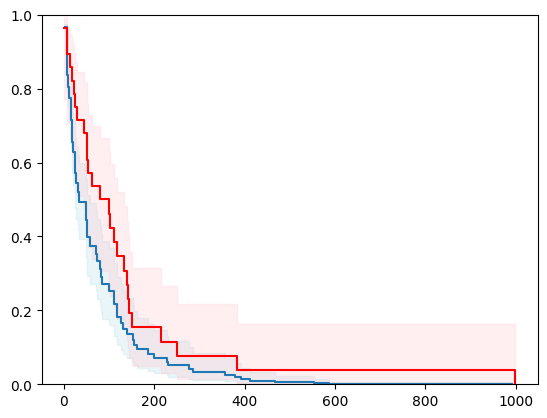

In [63]:
X, y = load_veterans_lung_cancer()
X = _encode_categorical_columns(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

event_time = [y[1] for y in y_test]
event_status = [y[0] for y in y_test]
km = kaplan_meier_estimator(event_status, event_time,
                            conf_type="log-log")
estimator = PIComponentwiseGenGradientBoostingSurvivalAnalysis(regr=RidgeCV(), type_pi="kde")
estimator2 = GradientBoostingSurvivalAnalysis()

start = time()
estimator.fit(X_train, y_train)
print("Time to fit PIRandomForestRegressor: ", time() - start)

surv_funcs = estimator.predict_survival_function(X_test.iloc[:1])

for fn in surv_funcs.mean:
    plt.step(fn.x, fn(fn.x), where="post")
    plt.fill_between(fn.x, surv_funcs.lower[0].y, surv_funcs.upper[0].y, alpha=0.25, color="lightblue", step="post")
    plt.step(km[0], km[1], where="post", color="red", label="Kaplan-Meier")
    plt.fill_between(km[0], km[2][0], km[2][1], alpha=0.25, color="pink", step="post")
    plt.ylim(0, 1)
    plt.show()

  9%|▉         | 9/100 [00:00<00:01, 87.79it/s]

100%|██████████| 100/100 [00:01<00:00, 81.17it/s]


Time to fit PIRandomForestRegressor:  2.4110536575317383


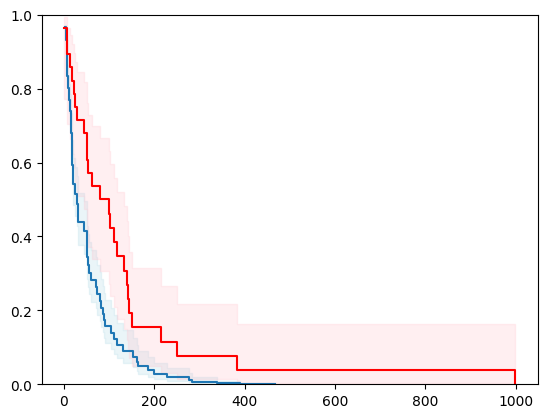

In [64]:
X, y = load_veterans_lung_cancer()
X = _encode_categorical_columns(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

event_time = [y[1] for y in y_test]
event_status = [y[0] for y in y_test]
km = kaplan_meier_estimator(event_status, event_time,
                            conf_type="log-log")
estimator = PIComponentwiseGenGradientBoostingSurvivalAnalysis(regr=RidgeCV(), type_pi="ecdf")
estimator2 = GradientBoostingSurvivalAnalysis()

start = time()
estimator.fit(X_train, y_train)
print("Time to fit PIRandomForestRegressor: ", time() - start)

surv_funcs = estimator.predict_survival_function(X_test.iloc[:1])

for fn in surv_funcs.mean:
    plt.step(fn.x, fn(fn.x), where="post")
    plt.fill_between(fn.x, surv_funcs.lower[0].y, surv_funcs.upper[0].y, alpha=0.25, color="lightblue", step="post")
    plt.step(km[0], km[1], where="post", color="red", label="Kaplan-Meier")
    plt.fill_between(km[0], km[2][0], km[2][1], alpha=0.25, color="pink", step="post")
    plt.ylim(0, 1)
    plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:01<00:00, 81.30it/s]


Time to fit PIRandomForestRegressor:  2.4172897338867188


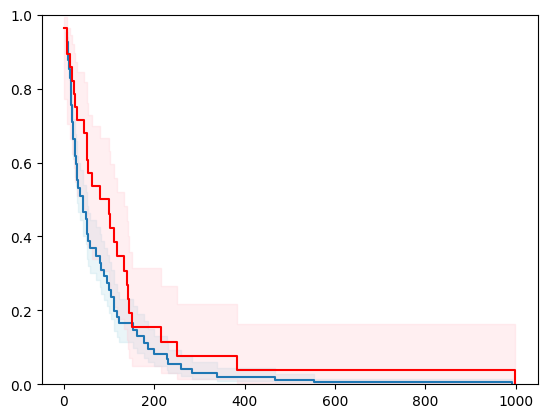

In [65]:
X, y = load_veterans_lung_cancer()
X = _encode_categorical_columns(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

event_time = [y[1] for y in y_test]
event_status = [y[0] for y in y_test]
km = kaplan_meier_estimator(event_status, event_time,
                            conf_type="log-log")
estimator = PIComponentwiseGenGradientBoostingSurvivalAnalysis(regr=RidgeCV(), type_pi="kde")
estimator2 = GradientBoostingSurvivalAnalysis()

start = time()
estimator.fit(X_train, y_train)
print("Time to fit PIRandomForestRegressor: ", time() - start)

surv_funcs = estimator.predict_survival_function(X_test.iloc[:1])

for fn in surv_funcs.mean:
    plt.step(fn.x, fn(fn.x), where="post")
    plt.fill_between(fn.x, surv_funcs.lower[0].y, surv_funcs.upper[0].y, alpha=0.25, color="lightblue", step="post")
    plt.step(km[0], km[1], where="post", color="red", label="Kaplan-Meier")
    plt.fill_between(km[0], km[2][0], km[2][1], alpha=0.25, color="pink", step="post")
    plt.ylim(0, 1)
    plt.show()

# Bayesian

In [66]:
import matplotlib.pyplot as plt
import nnetsauce as ns
import numpy as np
from survivalist.datasets import load_whas500, load_veterans_lung_cancer, load_gbsg2
from survivalist.custom import SurvivalCustom
from sklearn.linear_model import BayesianRidge, ARDRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.neural_network import MLPRegressor
from survivalist.metrics import brier_score, integrated_brier_score
from time import time

import pandas as pd

def encode_categorical_columns(df, categorical_columns=None):
    """
    Automatically identifies categorical columns and applies one-hot encoding.

    Parameters:
    - df (pd.DataFrame): The input DataFrame with mixed continuous and categorical variables.
    - categorical_columns (list): Optional list of column names to treat as categorical.

    Returns:
    - pd.DataFrame: A new DataFrame with one-hot encoded categorical columns.
    """
    # Automatically identify categorical columns if not provided
    if categorical_columns is None:
        categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()

    # Apply one-hot encoding to the identified categorical columns
    df_encoded = pd.get_dummies(df, columns=categorical_columns)

    # Convert boolean columns to integer (0 and 1)
    bool_columns = df_encoded.select_dtypes(include=['bool']).columns.tolist()
    df_encoded[bool_columns] = df_encoded[bool_columns].astype(int)

    return df_encoded


X, y = load_veterans_lung_cancer()
X = encode_categorical_columns(X)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.4,
                                                    random_state=42)

print("\n\n BayesianRidge ------------------")

estimator = SurvivalCustom(regr=ns.CustomRegressor(BayesianRidge()))
estimator2 = SurvivalCustom(regr=ns.CustomRegressor(GaussianProcessRegressor()))
estimator3 = SurvivalCustom(regr=ns.CustomRegressor(ARDRegression()))

start = time()
estimator.fit(X_train, y_train)
print("Time to fit BayesianRidge: ", time() - start)
start = time()
estimator2.fit(X_train, y_train)
print("Time to fit GaussianProcessRegressor: ", time() - start)
start = time()
estimator3.fit(X_train, y_train)
print("Time to fit ARDRegression: ", time() - start)


surv_funcs = estimator.predict_survival_function(X_test.iloc[0:1,:], return_std=True)
surv_funcs2 = estimator2.predict_survival_function(X_test.iloc[0:1,:], return_std=True)
surv_funcs3 = estimator3.predict_survival_function(X_test.iloc[0:1,:], return_std=True)

print("\n\n BayesianRidge survival func (mean)", surv_funcs.mean)
print("\n\n BayesianRidge survival func (lower)", surv_funcs.lower)
print("\n\n BayesianRidge survival func (upper)", surv_funcs.upper)

print("\n\n GaussianProcessRegressor survival func (mean)", surv_funcs2.mean)
print("\n\n GaussianProcessRegressor survival func (lower)", surv_funcs2.lower)
print("\n\n GaussianProcessRegressor survival func (upper)", surv_funcs2.upper)

print("\n\n ARDRegression survival func (mean)", surv_funcs3.mean)
print("\n\n ARDRegression survival func (lower)", surv_funcs3.lower)
print("\n\n ARDRegression survival func (upper)", surv_funcs3.upper)



 BayesianRidge ------------------
Time to fit BayesianRidge:  0.13642525672912598
Time to fit GaussianProcessRegressor:  0.23502564430236816
Time to fit ARDRegression:  0.2868978977203369


 BayesianRidge survival func (mean) [StepFunction(x=array([  2.,   3.,   4.,   7.,   8.,  10.,  11.,  12.,  13.,  15.,  16.,
         18.,  19.,  20.,  21.,  24.,  25.,  29.,  31.,  33.,  36.,  49.,
         51.,  52.,  53.,  56.,  59.,  80.,  82.,  84.,  87.,  90.,  92.,
         95.,  97., 100., 103., 105., 110., 111., 112., 117., 122., 123.,
        126., 132., 140., 164., 177., 182., 186., 200., 201., 228., 231.,
        278., 283., 287., 314., 340., 357., 378., 392., 411., 467., 553.,
        587., 991.]), y=array([9.69111530e-01, 9.38525577e-01, 9.08207350e-01, 8.21619515e-01,
        7.92785179e-01, 7.64664683e-01, 7.37147307e-01, 6.84662047e-01,
        6.58885898e-01, 6.09020904e-01, 5.84902578e-01, 5.61180915e-01,
        5.37835387e-01, 4.93062369e-01, 4.49919235e-01, 4.28629673e-01,
  

In [67]:
event_time = [y[1] for y in y_test]
event_status = [y[0] for y in y_test]
km = kaplan_meier_estimator(event_status, event_time,
                            conf_type="log-log")


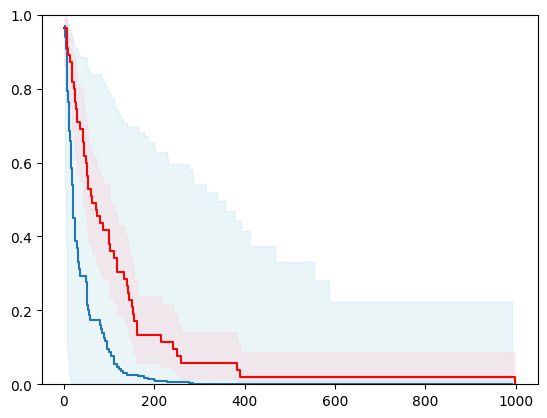

In [68]:
for fn in surv_funcs.mean:
    plt.step(fn.x, fn(fn.x), where="post")
    plt.fill_between(fn.x, surv_funcs.lower[0].y, surv_funcs.upper[0].y, alpha=0.25, color="lightblue", step="post")
    plt.step(km[0], km[1], where="post", color="red", label="Kaplan-Meier")
    plt.fill_between(km[0], km[2][0], km[2][1], alpha=0.25, color="pink", step="post")
    plt.ylim(0, 1)
    plt.show()

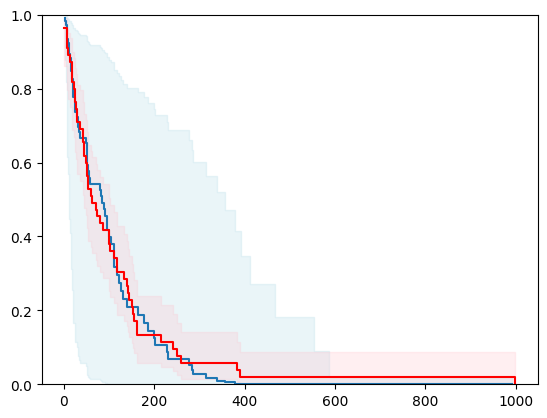

In [69]:
for fn in surv_funcs2.mean:
    plt.step(fn.x, fn(fn.x), where="post")
    plt.fill_between(fn.x, surv_funcs2.lower[0].y, surv_funcs2.upper[0].y, alpha=0.25, color="lightblue", step="post")
    plt.step(km[0], km[1], where="post", color="red", label="Kaplan-Meier")
    plt.fill_between(km[0], km[2][0], km[2][1], alpha=0.25, color="pink", step="post")
    plt.ylim(0, 1)
    plt.show()

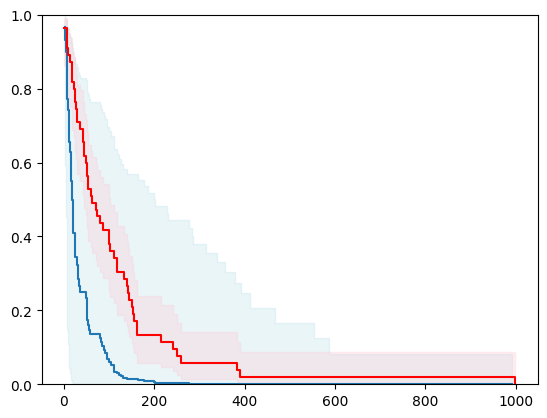

In [70]:
for fn in surv_funcs3.mean:
    plt.step(fn.x, fn(fn.x), where="post")
    plt.fill_between(fn.x, surv_funcs3.lower[0].y, surv_funcs3.upper[0].y, alpha=0.25, color="lightblue", step="post")
    plt.step(km[0], km[1], where="post", color="red", label="Kaplan-Meier")
    plt.fill_between(km[0], km[2][0], km[2][1], alpha=0.25, color="pink", step="post")
    plt.ylim(0, 1)
    plt.show()